**Examples**

Drag

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

Downloaded modsim.py


In [2]:
from modsim import *

The Params Object

In [3]:
params = Params(        #all units
    mass = 0.0025,      # kg
    diameter = 0.019,   # m
    rho = 1.2,          # kg/m**3
    g = 9.8,            # m/s**2
    v_init = 0,         # m / s
    v_term = 18,        # m / s
    height = 381,       # m
    t_end = 30,         # s
)

In [4]:
from numpy import pi

def make_system(params):
    init = State(y=params.height, v=params.v_init)

    area = pi * (params.diameter/2)**2

    C_d = (2 * params.mass * params.g /
           (params.rho * area * params.v_term**2))

    return System(init=init,
                  area=area,
                  C_d=C_d,
                  mass=params.mass,
                  rho=params.rho,
                  g=params.g,
                  t_end=params.t_end)

In [5]:
system = make_system(params)
system.C_d

0.4445009981135434

In [6]:
params2 = params.set(v_term=20)
system2 = make_system(params2)
system2.C_d

0.3600458084719701

Simulating the Penny Drop

In [7]:
def slope_func(t, state, system):
    y, v = state
    rho, C_d, area = system.rho, system.C_d, system.area
    mass, g = system.mass, system.g

    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    dydt = v
    dvdt = -g + a_drag

    return dydt, dvdt

slope_func(0, system.init, system)

def event_func(t, state, system):
    y, v = state
    return y

results, details = run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

In [8]:
results.tail()

,y,v
21.541886,1.614743e+01,-18.001510
21.766281,1.211265e+01,-18.006240
21.990676,8.076745e+00,-18.009752
22.215070,4.039275e+00,-18.011553
22.439465,2.131628e-14,-18.011383


In [9]:
t_sidewalk = results.index[-1]
t_sidewalk

22.439465058044306

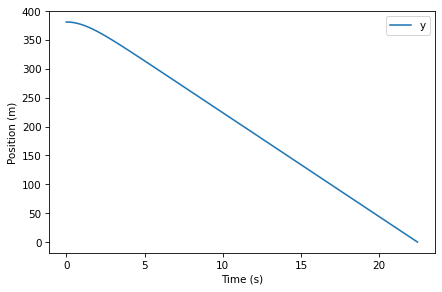

In [10]:
def plot_position(results):
    results.y.plot()
    decorate(xlabel='Time (s)', ylabel='Position (m)')

plot_position(results)

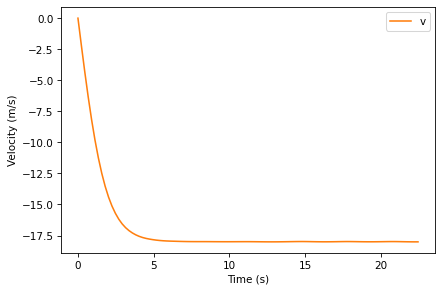

In [11]:
def plot_velocity(results):
    results.v.plot(color='C1', label='v')
    decorate(xlabel='Time (s)', ylabel='Velocity (m/s)')

plot_velocity(results)

**Exercises**

Exercise 1

In [12]:
params = params.set(v_init=-30)
system2 = make_system(params)
results2, details2 = run_solve_ivp(system2, slope_func, events=event_func)
details2.message

'A termination event occurred.'

In [13]:
t_sidewalk = results2.index[-1]
t_sidewalk

20.635183673114156

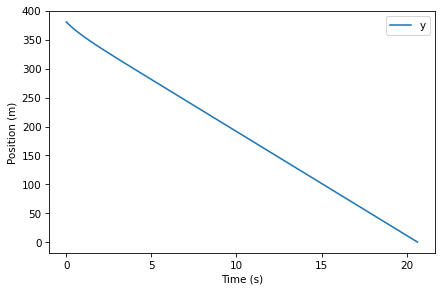

In [14]:
plot_position(results2)

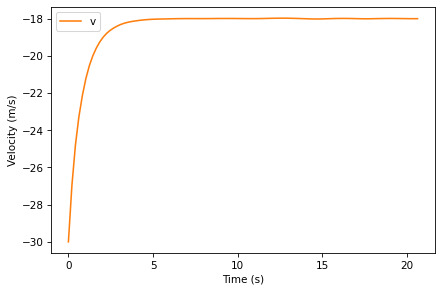

In [15]:
plot_velocity(results2)

Exercise 2

In [16]:
params_quarter = params.set(#All units
    mass = 0.0057,          # kg
    diameter = 0.024,       # m
    flight_time = 19.1,     # s
)
system3 = make_system(params_quarter)
results3, details3 = run_solve_ivp(system3, slope_func, events=event_func)
details3.message

'A termination event occurred.'

In [17]:
t_sidewalk = results3.index[-1]
t_sidewalk

20.635183673114057

In [18]:
def error_func(guess, params):
    """Final height as a function of C_d.

    guess: guess at v_term
    params: Params object

    returns: height in m
    """
    print(guess)
    params = params.set(v_term=guess)
    system = make_system(params)
    results, details = run_solve_ivp(system, slope_func, events=event_func)
    t_sidewalk = results.index[-1]
    error = t_sidewalk - params.flight_time
    return error
v_guess1 = 18
error_func(v_guess1, params_quarter)

18


1.5351836731140551

In [19]:
v_guess2 = 22
error_func(v_guess2, params_quarter)

22


-2.1591256962719925

In [20]:
res = root_scalar(error_func, params_quarter, bracket=[v_guess1, v_guess2])
v_term = res.root
v_term

18
18.0
22.0
19.66221452468036
19.475274945870474
19.45967387499707
19.46064685869182


19.45967387499707

In [21]:
system4 = make_system(params_quarter.set(v_term=res.root))
system4.C_d

0.54345826868176